In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from google.colab import drive
drive.mount('/content/drive')
# device='cuda' if torch.cuda.is_available() else 'cpu'
# print(torch.cuda.get_device_name(0))

filenames=['./drive/My Drive/gnn/ieee24_rts_6183exact_0810.txt', # exact nodal injection (generator included)
           './drive/My Drive/gnn/data/ieee118_dc_7859_price_lambda.txt', # load file (no gen)
           './drive/My Drive/gnn/data/ieee118_dc_8000_cost2price.txt',
           './drive/My Drive/gnn/data/ieee118_dc_8000_3input2price.txt',
           '/content/drive/MyDrive/gnn/data/ieee118_dc_8000_3input2price_new.txt'
           '/content/drive/MyDrive/gnn/data/ieee118_dc_10000_3input2price.txt',
           '/content/drive/MyDrive/gnn/data/ieee118_dc_10000_3input2price_p10.txt',
           '/content/drive/MyDrive/gnn/data/ieee118_dc_20000_3input2price_p10.txt',
           '/content/drive/MyDrive/gnn/data/ieee118_ac_20000_3input2price_p10_1.txt',
           '/content/drive/MyDrive/gnn/data/data_2383dc_3inputs/ieee2383_dc_3input2price_p10_1.txt']
filename=filenames[-1]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_table(filename,sep=',',header=None).to_numpy()
## load injection
# system size
n_bus=int(data[0,0].copy())
n_line=int(data[1,0].copy()) # not concatenated
n_line=2887
n_load=int(data[2,0].copy())
n_sample=int(data[3,0].copy())
# line
line_bus=data[:,1:3].copy()
# load data
load_data0=data[0:n_bus,3:n_sample+3].copy()
# generator cost data
gen_cost0=data[0:n_bus,n_sample+3:2*n_sample+3].copy()
# generator limit data
gen_limit0=data[0:n_bus,2*n_sample+3:3*n_sample+3].copy()
# LMP data
lmp_data=data[0:n_bus,3*n_sample + 3 : 4*n_sample + 3].copy()
# generation data
gen_data=data[0:n_bus,4*n_sample + 3 : 5*n_sample + 3].copy()
y0=lmp_data.copy()
print(n_sample)
print(np.max(gen_cost0),np.min(gen_cost0))
# Use partial data for faster test
n_sample=n_sample

# # before 05/20, 3 inputs
# load_data=np.zeros((n_bus,3,n_sample))
# load_data[:,0,:]=load_data0[:,:n_sample].copy()
# load_data[:,1,:]=gen_cost0[:,:n_sample].copy()
# load_data[:,2,:]=gen_limit0[:,:n_sample].copy()

# 05/20, limits as inputs (upper and lower)
load_data=np.zeros((n_bus,3,n_sample))
load_data[:,0,:]= gen_limit0[:,:n_sample].copy() - load_data0[:,:n_sample].copy() # upper
load_data[:,1,:]= - load_data0[:,:n_sample].copy() # lower
load_data[:,2,:]=gen_cost0[:,:n_sample].copy()
# load_data[:,2,:]=gen_limit0[:,:n_sample].copy()

y0=y0[:,:n_sample].copy()*1
# print system info
print('Test case: ',filename)
print('Number of buses: ',n_bus)
print('Number of lines: ',n_line)
print('Number of loads: ',n_load)
print('Number of samples: ',n_sample)

3952
204.89 0.0
Test case:  /content/drive/MyDrive/gnn/data/data_2383dc_3inputs/ieee2383_dc_3input2price_p10_1.txt
Number of buses:  2383
Number of lines:  2887
Number of loads:  1822
Number of samples:  3952


In [ ]:
# filename = './drive/My Drive/gnn/data/ieee118_nominal_price.txt' # load file (no gen)
# filename='./drive/My Drive/gnn/data/ieee118_nominal_cost2price.txt'
# nominal_data=pd.read_table(filename,sep=',',header=None).to_numpy() # range [-0.4,0.5]
# load_nominal=nominal_data[:,0].copy()
# lmp_nominal=nominal_data[:,1].copy()
for i in range(n_sample):
  # load_data[:,i] = load_data[:,i] - load_nominal
  y0[:,i] = y0[:,i] #- lmp_nominal
  load_data[:,:,i] = load_data[:,:,i] #- load_nominal  #/ 400
# y0 = y0 / 1500
# load_data = np.log(load_data+1) # +1 to avoid -inf in load, scaling / 300
# y0 = np.log(y0) 
print(load_data.shape,y0.shape)
# print(load_data[:,1:5],y0[:,1:5])
print(np.max(load_data),np.min(load_data),np.max(y0),np.min(y0))#,max(lmp_nominal),min(lmp_nominal))

(2383, 3, 3952) (2383, 3952)
3391.5600000000004 -434.89 894.45 -204.75


In [ ]:
filename='./drive/MyDrive/gnn/data/data_2383dc_3inputs/ieee2383_Bbus.txt' # load file (no gen)
B=pd.read_table(filename,sep=',',header=None).to_numpy() # range [-0.4,0.5]
print(B.shape,type(B))

line_src=line_bus[:,0].copy().astype(int)
line_dst=line_bus[:,1].copy().astype(int)
print('Original graph:')
print('There are %d nodes.' % n_bus)
print('There are %d edges.' % n_line)

# adjacency
def graph_v2v_mat(line,n_line,n_bus):
	w = np.zeros((n_bus,n_bus))
	for i in range(n_line):
		# print(int(line[i,0]),int(line[i,1]))
		w[int(line[i,0])-1,int(line[i,1])-1] = 1
		w[int(line[i,1])-1,int(line[i,0])-1] = 1
	return w

def graph_laplacian(line,n_line,n_bus):
	incidence = np.zeros((n_line,n_bus))
	for i in range(n_line):
		# print(int(line[i,0]),int(line[i,1]))
		incidence[i,int(line[i,0])-1] = incidence[i,int(line[i,0])-1] + 1 # source
		incidence[i,int(line[i,1])-1] = incidence[i,int(line[i,1])-1] - 1 # destination
	w = np.matmul(incidence.transpose(),incidence)
	return w
W = graph_laplacian(line_bus,n_line,n_bus) # v2v
A = graph_v2v_mat(line_bus,n_line,n_bus)
# W=np.abs(W)

(2383, 2383) <class 'numpy.ndarray'>
Original graph:
There are 2383 nodes.
There are 2887 edges.


In [ ]:
x_all=load_data[0:n_bus,:]
y_all=y0[:,0:n_sample]

In [ ]:
# np.save('/content/drive/MyDrive/gnn/data/dc118_p10_x.npy',arr=x_all)
# np.save('/content/drive/MyDrive/gnn/data/dc118_p10_y.npy',arr=y_all)
np.save('/content/drive/MyDrive/gnn/data/2383dc_w.npy',arr=W)

In [ ]:
print(W)
w1 = np.matmul(W,W)
a1 = np.matmul(A,A)
# print(W[1,:])
# print(np.sum(w1[1,:]),w1[1,:])
# print(A[1,:])
# print(a1[1,:])

[[ 2.  0.  0. ...  0.  0.  0.]
 [ 0.  2.  0. ...  0.  0.  0.]
 [ 0.  0.  3. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  2.  0.]
 [ 0.  0.  0. ...  0.  0.  2.]]


# Load more datasets
* Combine into one

In [ ]:
filename = ['/content/drive/MyDrive/gnn/data/data_2383dc_3inputs/ieee2383_dc_3input2price_p10_2.txt',
            '/content/drive/MyDrive/gnn/data/data_2383dc_3inputs/ieee2383_dc_3input2price_p10_3.txt',
            '/content/drive/MyDrive/gnn/data/data_2383dc_3inputs/ieee2383_dc_3input2price_p10_4.txt',]
for i in range(3):
  data=pd.read_table(filename[i],sep=',',header=None).to_numpy()
  ## load injection
  # system size
  n_bus=int(data[0,0].copy())
  n_line=int(data[1,0].copy()) # not concatenated
  n_load=int(data[2,0].copy())
  n_sample=int(data[3,0].copy())
  # line
  line_bus=data[:,1:3].copy()
  # load data
  load_data0=data[0:n_bus,3:n_sample+3].copy()
  # generator cost data
  gen_cost0=data[0:n_bus,n_sample+3:2*n_sample+3].copy()
  # generator limit data
  gen_limit0=data[0:n_bus,2*n_sample+3:3*n_sample+3].copy()
  # LMP data
  lmp_data=data[0:n_bus,3*n_sample + 3 : 4*n_sample + 3].copy()
  # generation data
  gen_data=data[0:n_bus,4*n_sample + 3 : 5*n_sample + 3].copy()
  y0=lmp_data.copy()
  print(n_sample)
  # print(np.max(gen_cost0),np.min(gen_cost0))
  # Use partial data for faster test
  
  # # before 05/20, 3 inputs
  # load_data=np.zeros((n_bus,3,n_sample))
  # load_data[:,0,:]=load_data0[:,:n_sample].copy()
  # load_data[:,1,:]=gen_cost0[:,:n_sample].copy()
  # load_data[:,2,:]=gen_limit0[:,:n_sample].copy()

  # 05/20, limits as inputs (upper and lower)
  load_data=np.zeros((n_bus,3,n_sample))
  load_data[:,0,:]= gen_limit0[:,:n_sample].copy() - load_data0[:,:n_sample].copy() # upper
  load_data[:,1,:]= - load_data0[:,:n_sample].copy() # lower
  load_data[:,2,:]=gen_cost0[:,:n_sample].copy()
  # load_data[:,2,:]=gen_limit0[:,:n_sample].copy()

  x_all = np.append(x_all,load_data,axis=2)
  y_all = np.append(y_all,lmp_data,axis=1)

n_sample = np.size(y_all,1)
print(n_sample,x_all.shape,y_all.shape)

4030
4024
4050
16056 (2383, 3, 16056) (2383, 16056)


# Sorting out extreme cases
* Congestions will cause large deviations in LMP

In [ ]:
lmp_data = y_all.copy()

print(lmp_data.shape)
lmp_max = np.zeros(n_sample)
for i in range(n_sample):
  lmp_max[i] = np.max(lmp_data[:,i])
print(lmp_max,np.max(lmp_max))

(2383, 16056)
[659.26 148.37 191.24 ... 203.87 154.27 160.99] 1049.3


In [ ]:
lmp_dev = np.zeros(n_sample)
for i in range(n_sample):
  lmp_dev[i] = np.abs(np.max(lmp_data[:,i]) - np.min(lmp_data[:,i]))
print(lmp_dev,np.max(lmp_dev),np.min(lmp_dev))

[659.26   84.997 118.199 ... 110.591  93.339  89.389] 1113.52 0.0


In [ ]:
lmp_list = np.argsort(lmp_max)
print(lmp_list[0],lmp_max[lmp_list[0]])
print(lmp_list[16000],lmp_max[lmp_list[16000]])

lmp_list1 = np.argsort(lmp_dev)
print(lmp_list1[0],lmp_dev[lmp_list1[0]])
print(lmp_list1[16000],lmp_dev[lmp_list1[16000]])

13925 105.59
7159 769.21
8730 0.0
8276 772.633


In [ ]:
print(x_all.shape,y_all.shape)

# normal condition
n_save = 10000
x_all_2 = x_all[:,:,lmp_list1[0:n_save]]
y_all_2 = y_all[:,lmp_list1[0:n_save]]
print(x_all_2.shape,y_all_2.shape)
print(np.max(y_all_2),lmp_dev[lmp_list1[n_save]])

# heavy congestion
n_save = 4000
x_all_3 = x_all[:,:,lmp_list1[-n_save:]]
y_all_3 = y_all[:,lmp_list1[-n_save:]]
print(x_all_3.shape,y_all_3.shape)
print(np.max(y_all_3),np.mean(lmp_dev[lmp_list1[-n_save:]]))

(2383, 3, 16056) (2383, 16056)
(2383, 3, 10000) (2383, 10000)
254.0 149.366
(2383, 3, 4000) (2383, 4000)
1049.3 418.50306592025


In [ ]:
# np.save('/content/drive/MyDrive/gnn/data/2383dc_x.npy',arr=x_all_2)
# np.save('/content/drive/MyDrive/gnn/data/2383dc_y.npy',arr=y_all_2)

np.save('/content/drive/MyDrive/gnn/data/2383dc_2input_x.npy',arr=x_all_2)
np.save('/content/drive/MyDrive/gnn/data/2383dc_2input_y.npy',arr=y_all_2)

# np.save('/content/drive/MyDrive/gnn/data/ac118_p10_x_congest1.npy',arr=x_all_3)
# np.save('/content/drive/MyDrive/gnn/data/ac118_p10_y_congest1.npy',arr=y_all_3)

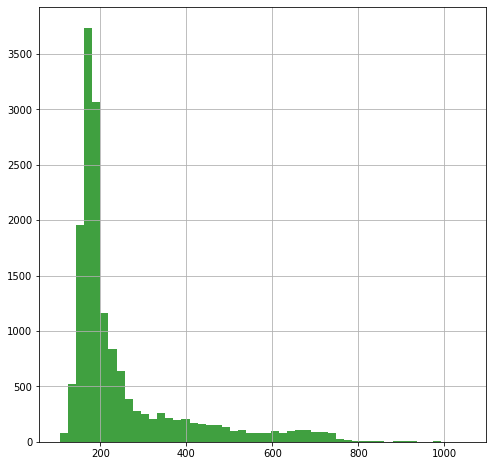

In [ ]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(8, 8))
plt.hist(lmp_max, bins = 50, facecolor='g', alpha=0.75)
plt.grid(True)
plt.show()